In [58]:
import numpy as np
import pandas as pd
# from sklearn.cluster import DBSCAN
import matplotlib.pyplot as plt

import pandas as pd
from scipy.spatial import distance_matrix
import numpy as np
import matplotlib.pyplot as plt
import itertools
import copy
from collections import Counter
from TrackReconstruction_functions import *

pd.options.mode.chained_assignment = None  # Disable the warning

pressure=5
diffusion="5.0percent"
# file_id = "1"
file_id = "2954"


# hits_true = pd.read_hdf(f"../data/ATPC_0nubb/ATPC_0nubb_{pressure}bar_smear_{file_id}.h5", "MC/hits")
# hits      = pd.read_hdf(f"../data/ATPC_0nubb/ATPC_0nubb_{pressure}bar_{diffusion}_smear_{file_id}.h5", "MC/hits")

hits_true = pd.read_hdf(f"../data/ATPC_Tl/ATPC_Tl_{pressure}bar_smear_{file_id}.h5", "MC/hits")
hits      = pd.read_hdf(f"../data/ATPC_Tl/ATPC_Tl_{pressure}bar_5.0percent_smear_{file_id}.h5", "MC/hits")


display(hits)

event_list = hits.event_id.unique()

print(hits.event_id.unique())

,event_id,x,y,z,energy
0,59400000,236.459244,1315.175049,2204.652100,0.000025
1,59400000,243.649796,1311.600708,2204.652344,0.000025
2,59400000,250.107498,1331.163452,2211.615967,0.000025
3,59400000,253.605270,1316.571411,2212.627930,0.000670
4,59400000,247.778625,1323.490234,2212.934082,0.000992
...,...,...,...,...,...
33580,59400059,-530.636658,1190.632446,3495.853027,0.000025
33581,59400059,-535.828064,1205.207031,3495.857666,0.000074
33582,59400059,-541.622009,1205.344360,3496.059326,0.000074
33583,59400059,-541.963440,1195.702026,3496.234863,0.000248


[59400000 59400001 59400002 59400003 59400004 59400005 59400006 59400007
 59400008 59400009 59400010 59400011 59400012 59400013 59400014 59400015
 59400016 59400017 59400018 59400019 59400020 59400021 59400022 59400023
 59400024 59400025 59400026 59400027 59400028 59400029 59400030 59400031
 59400032 59400033 59400034 59400035 59400036 59400037 59400038 59400039
 59400040 59400041 59400042 59400043 59400044 59400045 59400046 59400047
 59400048 59400049 59400050 59400051 59400052 59400053 59400054 59400055
 59400056 59400057 59400058 59400059]


In [59]:
eid=320000
eid=event_list[6]

data = hits[hits.event_id ==eid]
data_true = hits_true[hits_true.event_id ==eid]
display(data_true)

,event_id,x,y,z,energy
1043,59400006,1467.998657,1303.321045,2138.361084,0.002976
1044,59400006,1471.386963,1301.606567,2138.755371,0.015500
1045,59400006,1465.476807,1304.550049,2139.155029,0.008730
1046,59400006,1474.510010,1299.836182,2139.707520,0.005382
1047,59400006,1477.341797,1297.488281,2140.766357,0.006845
...,...,...,...,...,...
1242,59400006,1199.660400,1338.262573,2442.771240,0.005208
1243,59400006,1210.441772,1338.950439,2443.312744,0.008333
1244,59400006,1209.805664,1337.772705,2445.812500,0.023312
1245,59400006,1209.767212,1337.555542,2450.687012,0.148403


In [60]:

Diff_smear = 0.0
energy_threshold=0
diff_scale_factor=7 # this scales the radius size

# The percentage 0 is actually a small amount
if (diffusion == "0.05percent"):
    Diff_smear = 0.05 # mm / sqrt(cm)
elif (diffusion == "0.1percent"):
    Diff_smear = 0.95 # mm / sqrt(cm)
elif (diffusion == "0.25percent"):
    Diff_smear = 0.703 # mm / sqrt(cm)
elif (diffusion == "0.5percent"):
    Diff_smear = 0.507 # mm / sqrt(cm)
elif (diffusion == "5.0percent"):

    if (pressure == 1):
        Diff_smear = 0.290 # mm / sqrt(cm)
        diff_scale_factor=7
    elif (pressure == 5):
        Diff_smear = 0.270
        diff_scale_factor=5
        energy_threshold=0.001
    elif (pressure == 10):
        Diff_smear = 0.251
        diff_scale_factor=5
        energy_threshold=0.001
    elif (pressure == 15):
        Diff_smear = 0.258
        diff_scale_factor=5
        energy_threshold=0.001
    else:
        print("Error pressure not found")
else:
    print("Error CO2 percentage not defined at 75 V/cm field")

if (Diff_smear == 0.0):
    print("Error diffusion value not configured properly")


mean_sigma = round(diff_scale_factor*Diff_smear*np.sqrt(0.1*data.z.mean()))


# Calculate the detector half-length
det_size = int(np.cbrt(6000**3/pressure)/2.0) 

# Create the bins ---- 
xbw=mean_sigma
xmin=-det_size - mean_sigma/2 
xmax=det_size + mean_sigma/2

ybw=mean_sigma
ymin=-det_size - mean_sigma/2 
ymax=det_size + mean_sigma/2

# This shifts the z pos of the events so 0 is at anode
# can set this to zero
z_shift = det_size
# z_shift = 0

zbw=mean_sigma
zmin=-det_size + z_shift - mean_sigma/2 
zmax=det_size + z_shift + mean_sigma/2

xbw=mean_sigma
xmin=-det_size - mean_sigma/2 
xmax=det_size + mean_sigma/2

ybw=mean_sigma
ymin=-det_size - mean_sigma/2 
ymax=det_size + mean_sigma/2

# bins for x, y, z
xbins = np.arange(xmin, xmax+xbw, xbw)
ybins = np.arange(ymin, ymax+ybw, ybw)
zbins = np.arange(zmin, zmax+zbw, zbw)

# center bins for x, y, z
xbin_c = xbins[:-1] + xbw / 2
ybin_c = ybins[:-1] + ybw / 2
zbin_c = zbins[:-1] + zbw / 2

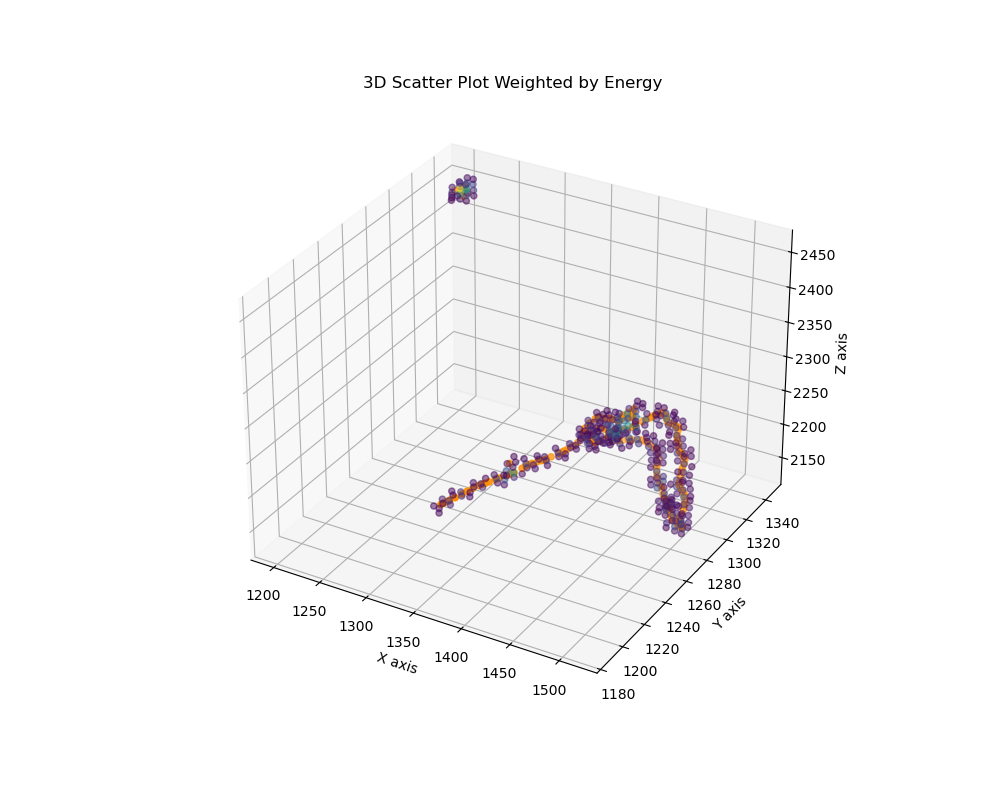

In [61]:
%matplotlib widget 

# Create a 3D scatter plot
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')


data = CutandRedistibuteEnergy(data, energy_threshold)

# Normalize the energy values for the colors
cmap = plt.get_cmap('viridis')
norm = plt.Normalize(data.energy.min(), data.energy.max())
colors = cmap(norm(data.energy))


# Plot the scatter plot
scatter = ax.scatter(data.x, data.y, data.z, c=colors, marker='o', alpha=0.5)
ax.scatter(data_true['x'], data_true['y'], data_true['z'], marker='o', c="DarkOrange")

# ax.scatter(data_true['x'], data_true['y'], data_true['z']+3000, marker='o', c="DarkRed")

# Add color bar to indicate energy values
mappable = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
mappable.set_array(data.energy)
# cbar = plt.colorbar(mappable)
# cbar.set_label('Energy')

# Set labels and title
ax.set_xlabel('X axis')
ax.set_ylabel('Y axis')
ax.set_zlabel('Z axis')
ax.set_title('3D Scatter Plot Weighted by Energy')

plt.show()

In [62]:
# There seems to be a duplicate row sometimes
data = data.drop_duplicates()

# display(data)
data = data[['event_id','x', 'y', 'z',"energy"]]

# shuffle the data to ensure we dont use g4 ordering
data = data.sample(frac=1).reset_index(drop=True)

# then sort it based on the x,y,z
data = data.sort_values(by=['x', "y", "z"]).reset_index(drop=True)

# Calculate the distance matrix
dist_matrix = distance_matrix(data[['x', 'y', 'z']], data[['x', 'y', 'z']])

display(data)
print(len(dist_matrix))

,event_id,x,y,z,energy
0,59400006,1198.057251,1337.170044,2440.403564,0.013151
1,59400006,1198.158325,1336.816772,2433.015625,0.001179
2,59400006,1198.198120,1344.052734,2440.831299,0.007101
3,59400006,1198.462646,1343.600830,2448.099854,0.002179
4,59400006,1198.565430,1336.938965,2448.105225,0.004845
...,...,...,...,...,...
290,59400006,1513.895752,1277.444458,2168.761230,0.004999
291,59400006,1514.254761,1283.229492,2160.649902,0.003461
292,59400006,1514.294922,1283.562744,2149.897705,0.005127
293,59400006,1514.677856,1276.482422,2159.612305,0.014099


295


Mean z: 2235.799  diffusion =  20
Mean Sigma:  20
31 2.3425087854266167


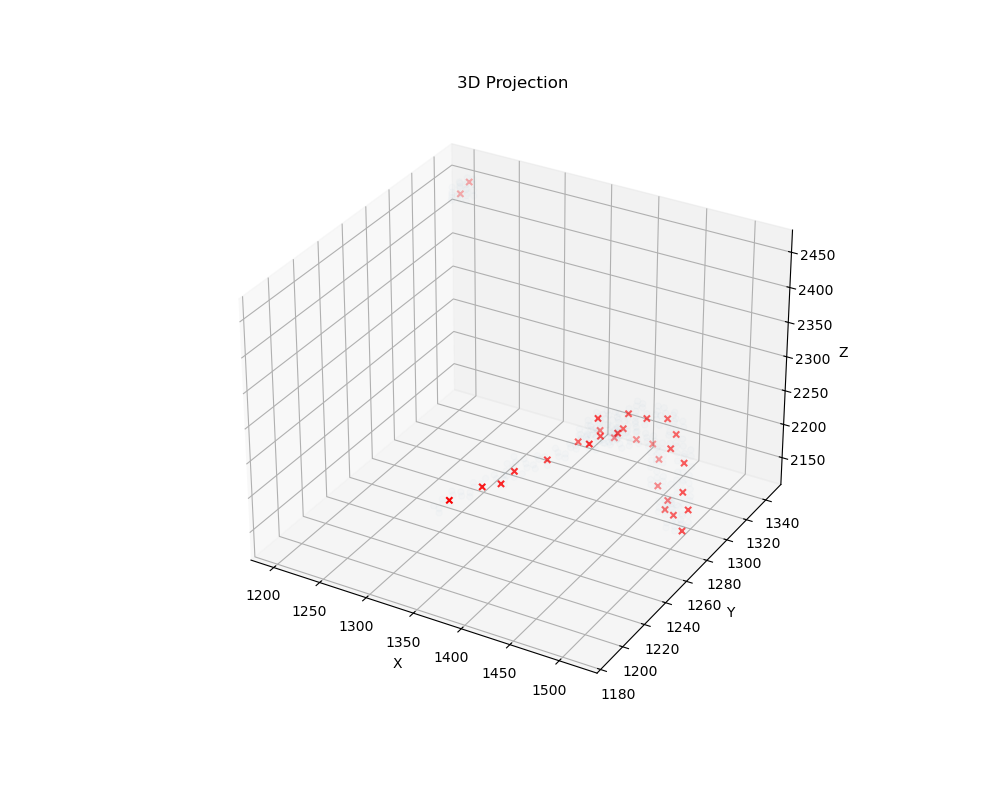

In [63]:

def GetMinima(index, all_visited_, input_data, temp_dist_matrix, R):


    distances_from_index = temp_dist_matrix[index] # distances for node to others
    sorted_indices = np.argsort(distances_from_index) # indexes sorted by smallest distance

    closest_nodes = sorted_indices[distances_from_index[sorted_indices] < R]
    
    closest_nodes = list(set(closest_nodes) - set(all_visited_))

    selected_rows = input_data.iloc[closest_nodes] # Df containing the nodes within distance

    # Compute the mean of x, y, and z columns
    mean_x = selected_rows['x'].median()
    mean_y = selected_rows['y'].median()
    mean_z = selected_rows['z'].median()
    energy_sum = selected_rows['energy'].sum()
    mean_point = np.array([mean_x, mean_y, mean_z, energy_sum])

    all_visited = all_visited_ + list(closest_nodes)

    return mean_point, all_visited


def Cluster(input_data, R):

    node_centers = []
    all_visited = []
    indexes = input_data.index.values
    indexes_set = set(indexes)

    temp_dist_matrix = distance_matrix(input_data[['x', 'y', 'z']], input_data[['x', 'y', 'z']])

    for i in range(len(input_data)):

        all_visited_set = set(all_visited)

        # Convert arrays to sets and perform the difference
        filtered_indexes = list(indexes_set - all_visited_set)

        if not filtered_indexes:
            break

        # random_index = np.random.choice(filtered_indexes)
        random_index = filtered_indexes[0]
        median, all_visited = GetMinima(random_index, all_visited, input_data, temp_dist_matrix, R)

        node_centers.append(median)

    return pd.DataFrame(node_centers, columns=['x', 'y', 'z', 'energy'])


print("Mean z:", data.z.mean(), " diffusion = ", mean_sigma)

# mean_sigma = round(6*0.29*np.sqrt(0.1*data.z.mean()))
# mean_sigma = round(6*0.9*np.sqrt(0.1*data.z.mean()))
print("Mean Sigma: ", mean_sigma)

node_centers_df = Cluster(data, mean_sigma)
# node_centers_df = Cluster(node_centers_df, 20)
# node_centers_df = Cluster(node_centers_df, 30)
# node_centers_df = Cluster(node_centers_df, 20)
# node_centers_df = Cluster(node_centers_df, 20)
# node_centers_df = Cluster(node_centers_df, 75)

# display(node_centers_df)
print(len(node_centers_df), node_centers_df.energy.sum())

# -------

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')


ax.scatter(data['x'], data['y'], data['z'], marker='o',alpha=0.01)
# ax.scatter(data_true['x'], data_true['y'], data_true['z'], marker='o')

ax.scatter(node_centers_df['x'], node_centers_df['y'], node_centers_df['z'], marker='x',c="r")



ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('3D Projection')
plt.show()



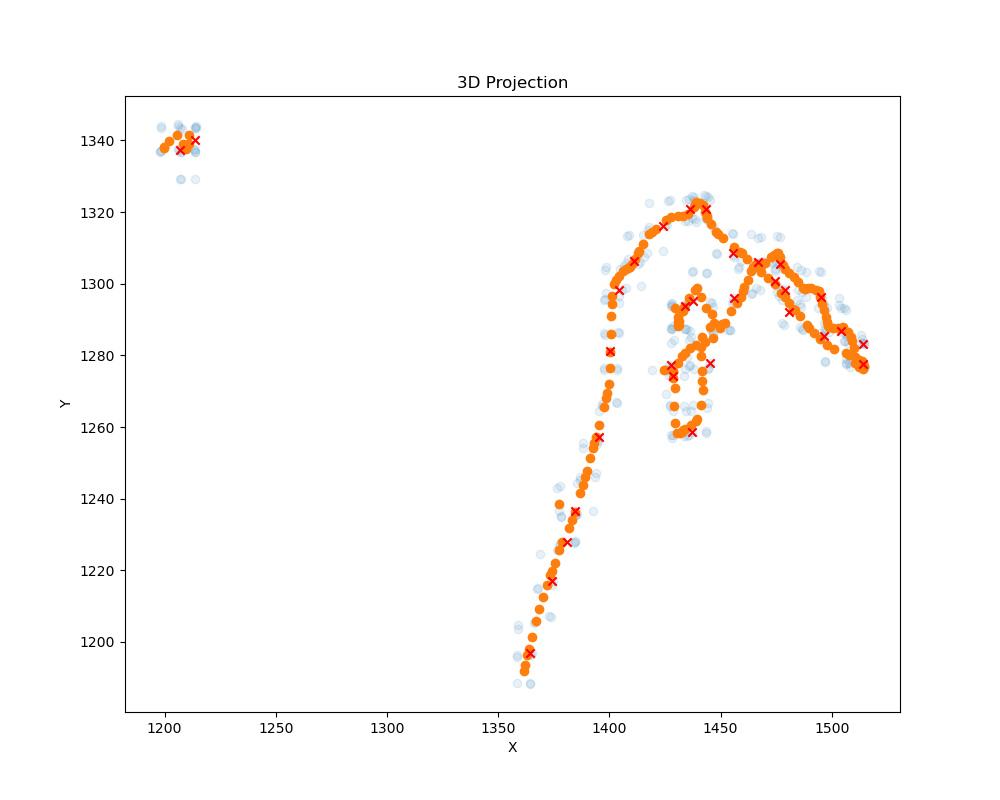

In [64]:
fig= plt.figure(figsize=(10, 8))

plt.scatter(data['x'], data['y'], marker='o',alpha=0.1)
plt.scatter(data_true['x'], data_true['y'], marker='o')
plt.scatter(node_centers_df['x'], node_centers_df['y'], marker='x',c="r")

plt.xlabel('X')
plt.ylabel('Y')

plt.title('3D Projection')
plt.show()


In [65]:


databin = node_centers_df.copy()
databin["event_id"] = eid

# Now lets bin the data
databin['x_smear'] = pd.cut(x=databin['x'], bins=xbins,labels=xbin_c, include_lowest=True)
databin['y_smear'] = pd.cut(x=databin['y'], bins=ybins,labels=ybin_c, include_lowest=True)
databin['z_smear'] = pd.cut(x=databin['z'], bins=zbins,labels=zbin_c, include_lowest=True)



# Drop rows with any NaN values
databin = databin.dropna()

# Dictionary to store results
aggregated_data = {}

# Iterate through the DataFrame row by row
for _, row in databin.iterrows():
    key = (row['event_id'], row['x_smear'], row['y_smear'], row['z_smear'])
    
    if key not in aggregated_data:
        # Initialize the aggregation for a new group
        aggregated_data[key] = {
            'x_sum': row['x'],
            'y_sum': row['y'],
            'z_sum': row['z'],
            'energy_sum': row['energy'],
            'count': 1
        }
    else:
        # Update existing group values
        aggregated_data[key]['x_sum'] += row['x']
        aggregated_data[key]['y_sum'] += row['y']
        aggregated_data[key]['z_sum'] += row['z']
        aggregated_data[key]['energy_sum'] += row['energy']
        aggregated_data[key]['count'] += 1

# Convert aggregated data into a DataFrame
result = []
for key, values in aggregated_data.items():
    event_id, x_smear, y_smear, z_smear = key
    result.append({
        'event_id': event_id,
        'x_smear': x_smear,
        'y_smear': y_smear,
        'z_smear': z_smear,
        'x': values['x_sum'] / values['count'],   # Mean x
        'y': values['y_sum'] / values['count'],   # Mean y
        'z': values['z_sum'] / values['count'],   # Mean z
        'energy': values['energy_sum']            # Sum energy
    })

# Create final DataFrame
databin = pd.DataFrame(result)
display(databin)


,event_id,x_smear,y_smear,z_smear,x,y,z,energy
0,59400006.0,1206.0,1346.0,2440.0,1206.996948,1337.421631,2440.997559,0.315876
1,59400006.0,1206.0,1346.0,2460.0,1213.795410,1340.002686,2457.365234,0.018021
2,59400006.0,1366.0,1206.0,2240.0,1364.386353,1196.946655,2247.902588,0.061575
3,59400006.0,1366.0,1226.0,2240.0,1374.342041,1216.930420,2241.769775,0.045502
4,59400006.0,1386.0,1246.0,2240.0,1384.625244,1236.585205,2239.645020,0.137942
5,59400006.0,1386.0,1226.0,2240.0,1380.980957,1227.802002,2232.903076,0.006383
6,59400006.0,1386.0,1266.0,2240.0,1395.275269,1257.106812,2230.954346,0.046374
7,59400006.0,1406.0,1286.0,2220.0,1400.413208,1281.153687,2224.924316,0.049450
8,59400006.0,1406.0,1306.0,2220.0,1404.469604,1298.313721,2218.900879,0.058653
9,59400006.0,1406.0,1306.0,2200.0,1410.889404,1306.429077,2199.088135,0.046220


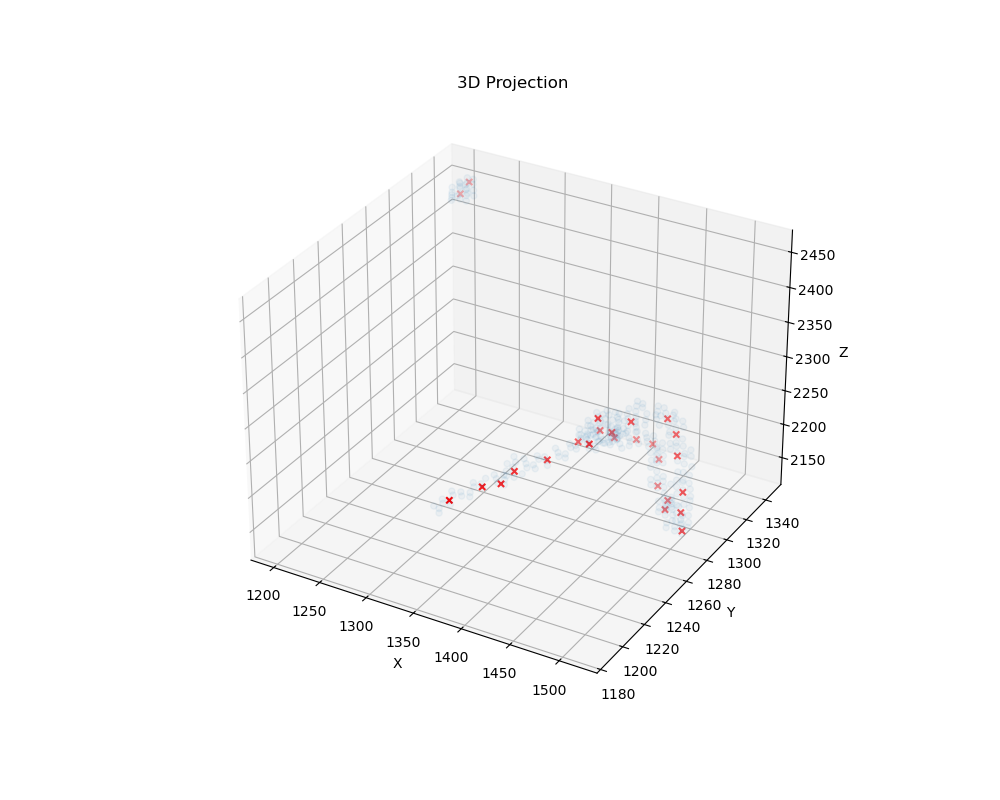

In [66]:
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')


ax.scatter(data['x'], data['y'], data['z'], marker='o',alpha=0.05)
# ax.scatter(data_true['x'], data_true['y'], data_true['z'], marker='o',color="Teal")

ax.scatter(databin['x'], databin['y'], databin['z'], marker='x',c="r")

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('3D Projection')
plt.show()

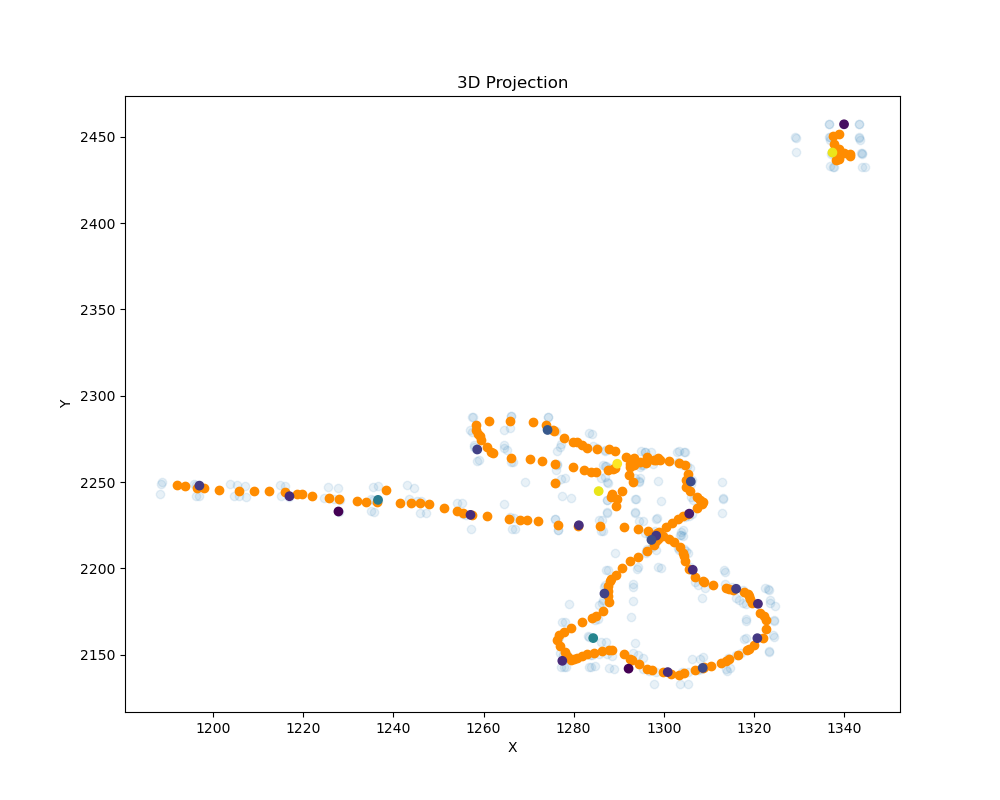

In [67]:
fig= plt.figure(figsize=(10, 8))

plt.scatter(data['y'], data['z'], marker='o',alpha=0.1)
plt.scatter(data_true['y'], data_true['z'], marker='o',color="DarkOrange")
# plt.scatter(data_true['y'], data_true['z'], marker='o',c=data_true["energy"])
plt.scatter(databin['y'], databin['z'], marker='o',c=databin['energy'])

plt.xlabel('X')
plt.ylabel('Y')

plt.title('3D Projection')
plt.show()

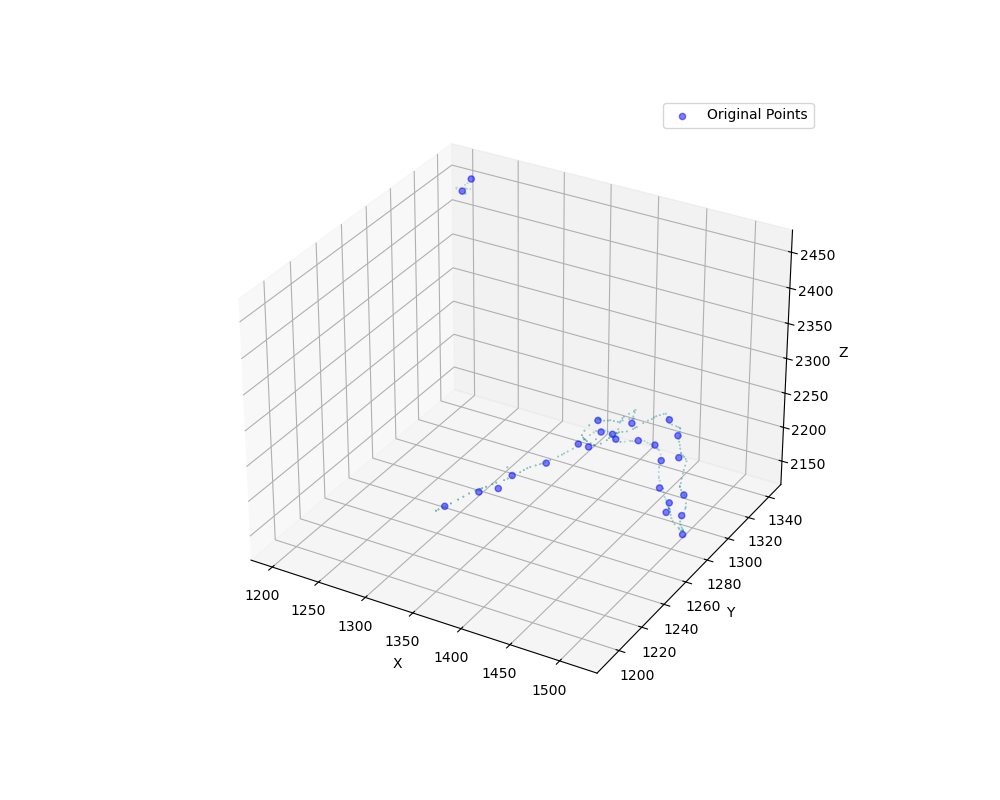

In [68]:

# Plot the original points and the polynomial fit
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(databin.x, databin.y,databin.z, color='blue', label='Original Points', alpha=0.5)
ax.scatter(data_true['x'], data_true['y'], data_true['z'],s=0.1 ,marker='o',color="Teal")

# Labels and legend
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.legend()
plt.show()

,event_id,x_smear,y_smear,z_smear,x,y,z,energy
0,59400006.0,1206.0,1346.0,2440.0,1206.996948,1337.421631,2440.997559,0.315876
1,59400006.0,1206.0,1346.0,2460.0,1213.795410,1340.002686,2457.365234,0.018021
2,59400006.0,1366.0,1206.0,2240.0,1364.386353,1196.946655,2247.902588,0.061575
3,59400006.0,1366.0,1226.0,2240.0,1374.342041,1216.930420,2241.769775,0.045502
4,59400006.0,1386.0,1246.0,2240.0,1384.625244,1236.585205,2239.645020,0.137942
5,59400006.0,1386.0,1226.0,2240.0,1380.980957,1227.802002,2232.903076,0.006383
6,59400006.0,1386.0,1266.0,2240.0,1395.275269,1257.106812,2230.954346,0.046374
7,59400006.0,1406.0,1286.0,2220.0,1400.413208,1281.153687,2224.924316,0.049450
8,59400006.0,1406.0,1306.0,2220.0,1404.469604,1298.313721,2218.900879,0.058653
9,59400006.0,1406.0,1306.0,2200.0,1410.889404,1306.429077,2199.088135,0.046220


Median distance to the closest row: 19.12673269088763
Dist Thresh 84.496
Pass Flag: True
The primary track is:  0
      event_id            x            y            z    energy  id  primary  \
0   59400006.0  1364.386353  1196.946655  2247.902588  0.061575   2        1   
1   59400006.0  1374.342041  1216.930420  2241.769775  0.045502   3        1   
2   59400006.0  1380.980957  1227.802002  2232.903076  0.006383   4        1   
3   59400006.0  1384.625244  1236.585205  2239.645020  0.137942   5        1   
4   59400006.0  1395.275269  1257.106812  2230.954346  0.046374   6        1   
5   59400006.0  1400.413208  1281.153687  2224.924316  0.049450   7        1   
6   59400006.0  1404.469604  1298.313721  2218.900879  0.058653   8        1   
7   59400006.0  1410.889404  1306.429077  2199.088135  0.046220   9        1   
8   59400006.0  1423.981079  1316.048828  2188.087402  0.064677  10        1   
9   59400006.0  1436.317627  1320.895264  2179.400879  0.045220  13        1   
10  59

,event_id,x,y,z,energy,id,primary,trkID,cumulative_distance,angle,Tortuosity,Squiglicity
id,,,,,,,,,,,,
2,59400006.0,1364.386353,1196.946655,2247.902588,0.061575,2,1,0,0.000000,0.000000,1.062694,0.175130
3,59400006.0,1374.342041,1216.930420,2241.769775,0.045502,3,1,0,23.153358,143.973125,1.054839,0.182879
4,59400006.0,1380.980957,1227.802002,2232.903076,0.006383,4,1,0,38.673823,19.977361,1.099227,0.320550
5,59400006.0,1384.625244,1236.585205,2239.645020,0.137942,5,1,0,50.330550,70.664193,1.102460,0.408363
6,59400006.0,1395.275269,1257.106812,2230.954346,0.046374,6,1,0,75.030493,56.129027,1.113086,0.497132
7,59400006.0,1400.413208,1281.153687,2224.924316,0.049450,7,1,0,100.348705,16.174697,1.154494,0.633053
8,59400006.0,1404.469604,1298.313721,2218.900879,0.058653,8,1,0,118.982087,5.218870,1.261488,0.950746
9,59400006.0,1410.889404,1306.429077,2199.088135,0.046220,9,1,0,141.334216,46.888460,1.353811,1.251327
10,59400006.0,1423.981079,1316.048828,2188.087402,0.064677,10,1,0,160.954300,29.928760,1.374406,1.363055


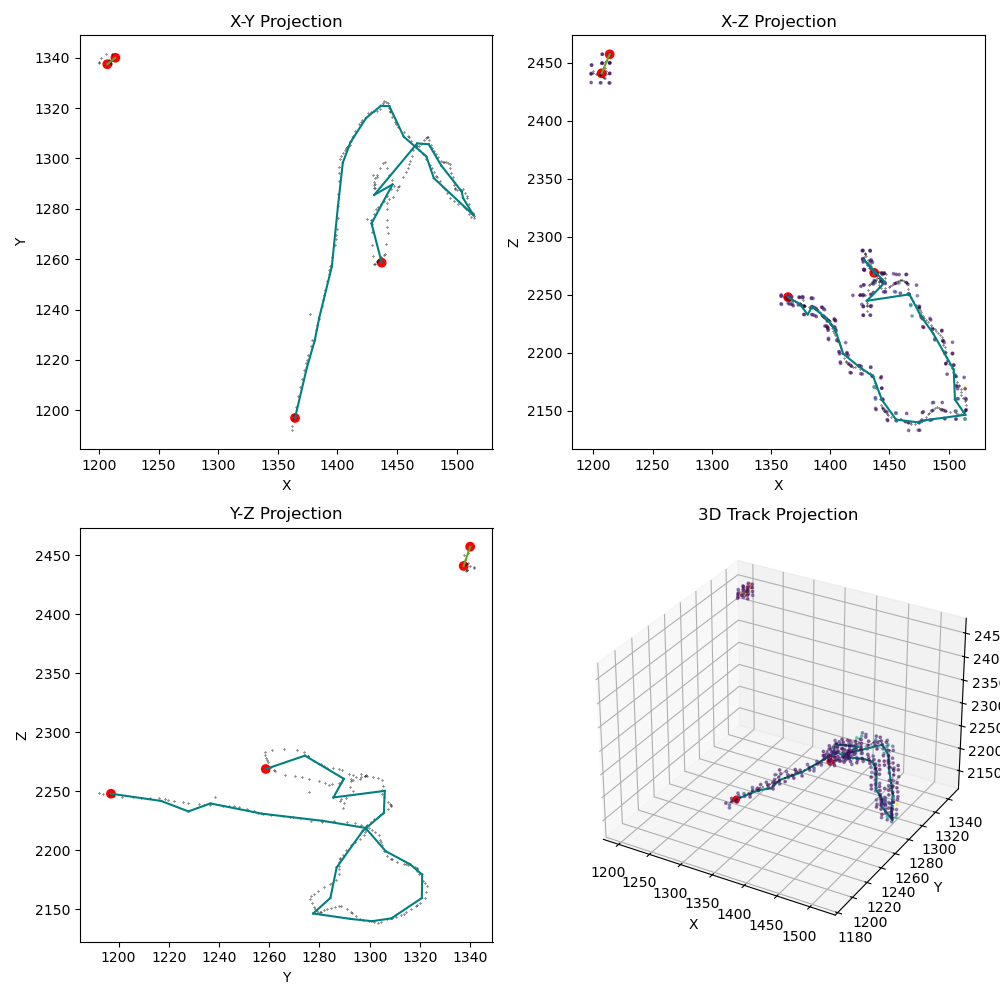

In [72]:
# Apply the tracking reconstruction

display(databin)


df, Tracks, connected_nodes, connection_count, pass_flag = RunTracking(databin[["event_id", "x", "y", "z", "energy"]], 0, 1, "5percent", 0)

df.index = df.id

display(df)

# Create subplots
fig = plt.figure(figsize=(10, 10))

axs = [fig.add_subplot(2, 2, i + 1) for i in range(3)]

# Plot xy projection
plot_tracks(axs[0], df['x'], df['y'], connection_count, 'X', 'Y', Tracks)
# axs[0].scatter(data.x, data.y, c=colors, marker='o', alpha=0.5,s=3)
axs[0].scatter(data_true['x'], data_true['y'], marker='o',c="k", s=0.1)

# Plot xz projection
plot_tracks(axs[1], df['x'], df['z'], connection_count, 'X', 'Z', Tracks)
axs[1].scatter(data.x, data.z, c=colors, marker='o', alpha=0.5,s=3)
axs[1].scatter(data_true['x'], data_true['z'], marker='o',c="k", s=0.1)

# Plot yz projection
plot_tracks(axs[2], df['y'], df['z'], connection_count, 'Y', 'Z', Tracks)
# axs[2].scatter(data.y, data.z, c=colors, marker='o', alpha=0.5,s=3)
axs[2].scatter(data_true['y'], data_true['z'], marker='o',c="k", s=0.1)


# 3D Projection
ax_3D = fig.add_subplot(2, 2, 4, projection='3d')
plot_tracks_3D(ax_3D, df['x'], df['y'], df['z'], connection_count, Tracks)
ax_3D.scatter(data_true['x'], data_true['y'], data_true['z'], marker='o',c="k", s=0.1)
ax_3D.scatter(data.x, data.y, data.z, c=colors, marker='o', alpha=0.5,s=3)

plt.tight_layout()
plt.show()

In [70]:
temp_meta = GetTrackdf(df, Tracks, 500/pressure, 180/pressure, 200/pressure,pressure) # scale these params inversely with the pressure
temp_meta = UpdateTrackMeta(temp_meta, df, 100/pressure) # Merge deltas and brems that are near the blobs in the metadata
display(temp_meta)

distance_threshold, radius_threshold, T_threshold, pressure:  100.0 36.0 40.0 5
end_tresh: 487.75380928564994 527.7538092856499 40.0 5 2
      event_id            x            y            z    energy  id  primary  \
id                                                                             
11  59400006.0  1428.565674  1274.205811  2280.171387  0.094388  11        1   
14  59400006.0  1437.076294  1258.609619  2268.848145  0.068420  14        1   

    trkID  cumulative_distance       angle  Tortuosity  Squiglicity  
id                                                                   
11      0           506.685168   91.817601    1.914774     0.983446  
14      0           527.753809  101.675717    1.906141     0.896003  
end_tresh: 487.75380928564994 527.7538092856499 40.0 5 2
      event_id            x            y            z    energy  id  primary  \
id                                                                             
11  59400006.0  1428.565674  1274.205811  228

,event_id,trkID,primary,start,end,length,energy,blob1,blob2,blob1R,blob2R,Tortuosity1,Tortuosity2,Squiglicity1,Squiglicity2,label
0,59400006.0,0,1,14,2,527.754,2.008612,0.802814,0.297777,0.487938,0.107078,201.253720,206.150232,98.993605,40.256378,Primary
0,59400006.0,1,0,0,1,17.910,0.333897,0.333897,0.333897,0.333897,0.333897,89.551904,89.551904,1.000000,1.000000,Brem


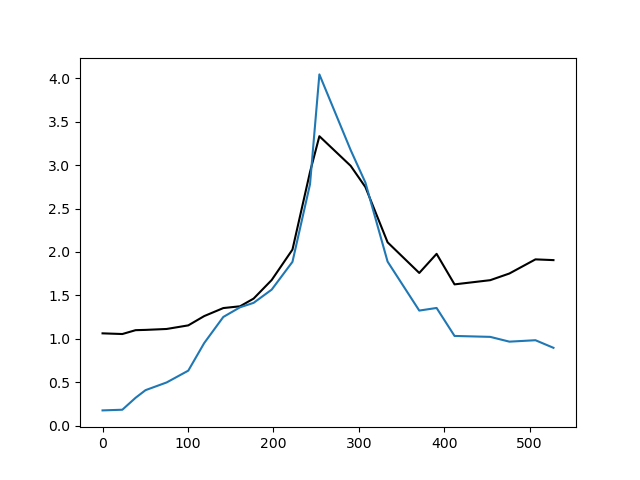

In [71]:
plt.figure()

plt.plot(df[df.primary == 1].cumulative_distance, df[df.primary == 1].Tortuosity, color="k");
plt.plot(df[df.primary == 1].cumulative_distance, df[df.primary == 1].Squiglicity);